# Packages

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd
import pickle
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

In [89]:
import warnings # Serve para ignorar mensagens de alerta que aparecem 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [90]:
plt.rcParams.update({
    'font.size': 18,
    'axes.linewidth':2,
    'axes.titlesize': 20,
    'lines.linewidth' : 1.5,
    'lines.markersize' : 10,
    'figure.figsize': (25,10),
    'xtick.labelsize': 15, 
    'ytick.labelsize': 15,
    'font.family': 'Arial',
    'legend.fontsize':14,
    'axes.labelsize':20,
    'axes.grid':True,
})

In [91]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Importing Buckley dataset

In [92]:
U = np.load('Buckley_Leveritt_dataset/Buckley.npy')

X = np.linspace(0,1,len(U))
T = np.linspace(0,1,len(U))
X, T = np.meshgrid(X,T)

In [93]:
X.shape

(500, 500)

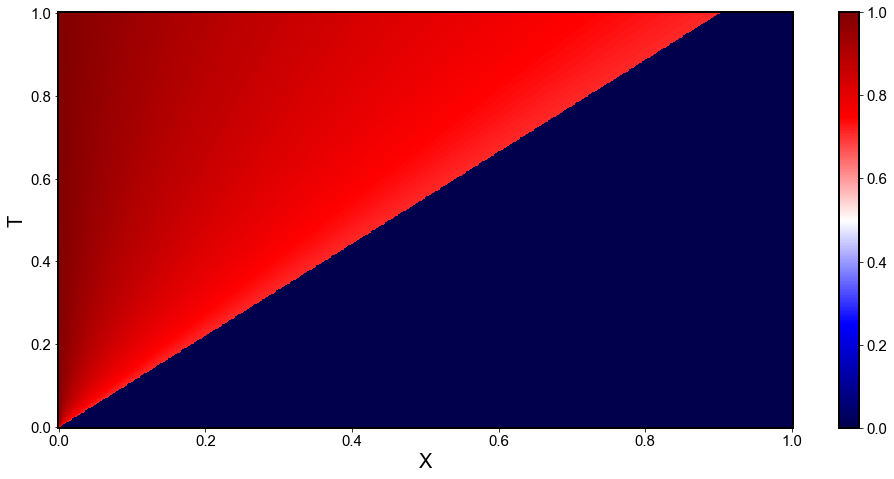

In [94]:
fig, ax = plt.subplots(figsize=(14, 7))

surf = ax.pcolor(X, T, U, cmap=plt.get_cmap("seismic"),shading='auto')

plt.colorbar(surf)
plt.xlabel('X')
plt.ylabel('T')
plt.tight_layout()

# Training and test set for PCA

In [95]:
X_train = X[:450]
T_train = T[:450]
U_train = U[:450]

X_test = X[450:]
T_test = T[450:]
U_test = U[450:]

In [96]:
# Normalizing the dataset to be with 0 mean and unit variance

scaler = StandardScaler()
U_scaled_train = scaler.fit_transform(U_train)
U_scaled_test = scaler.transform(U_test)

# Applying dimensionality reduction for the Kuramoto dataset - PCA

In [97]:
from utils import dim_reduction

In [98]:
pca = dim_reduction.pca(U=U,threshold=0.99)
path = './pca_models/pca_Buckley'
pca.save_model(path=path)

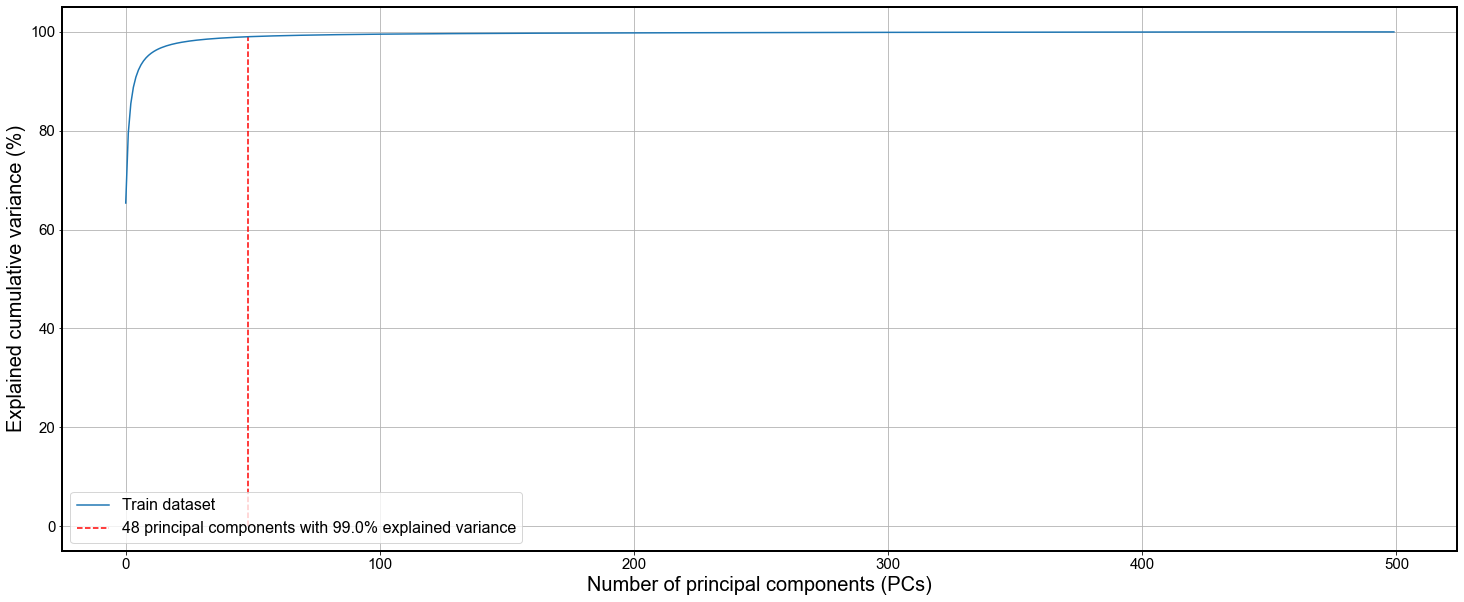

In [99]:
pca.plot_pca()

In [100]:
pca.model_red

PCA(copy=True, iterated_power='auto', n_components=48, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [101]:
U_train_pca = pca.model_red.fit_transform(U_scaled_train)
U_test_pca = pca.model_red.transform(U_scaled_test)

print(U_train_pca.shape)
print(U_scaled_train.shape)

(450, 48)
(450, 500)


In [102]:
U_train_reduced = pca.model_red.inverse_transform(U_train_pca)
U_test_reduced = pca.model_red.inverse_transform(U_test_pca)

print(U_train_reduced.shape)
print(U_scaled_train.shape)

U_train_reduced_inverse = scaler.inverse_transform(U_train_reduced)  # Apply inverse transform to obtain dataset in same scale as the original data
U_test_reduced_inverse = scaler.inverse_transform(U_test_reduced)

(450, 500)
(450, 500)


Mean absolute error (MAE) for training set: 0.01009282095927514


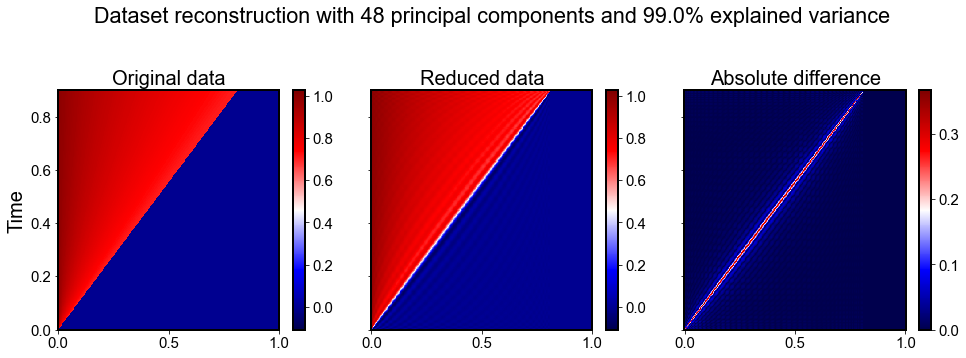

In [103]:
fig, ax, diff = pca.plot_compare(X=X_train,
                 T=T_train,
                 U = U_train,
                 U_reduced = U_train_reduced_inverse)

print('Mean absolute error (MAE) for training set: {}'.format(diff.mean()))

Mean absolute error (MAE) for test set: 0.034043533044286936


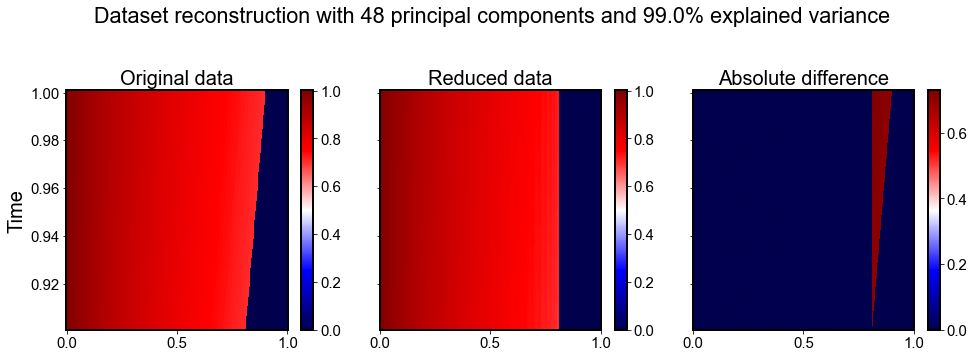

In [104]:
fig, ax, diff = pca.plot_compare(X=X_test,
                 T=T_test,
                 U = U_test,
                 U_reduced = U_test_reduced_inverse)

print('Mean absolute error (MAE) for test set: {}'.format(diff.mean()))

- PCA has difficulty in modeling the shock interface, as seen by the test set.

## Final ROM from Kuramoto equation

In [105]:
scaler2 = StandardScaler()
U_scaled2 = scaler2.fit_transform(U)

U_pca = pca.model_red.fit_transform(U_scaled2)
U_pca.shape

(500, 48)

In [106]:
pca.model_red

PCA(copy=True, iterated_power='auto', n_components=48, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [107]:
df = pd.DataFrame(U_pca)
df

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,28.272552,19.296020,-15.442553,13.218856,-11.698585,10.615700,-9.842846,9.188471,-8.596182,8.110078,...,0.329566,-0.252463,0.263655,-0.314710,-0.430719,-0.413848,-0.264232,0.282703,-0.202646,0.123973
1,28.159211,19.029829,-14.990199,12.551800,-10.794305,9.450515,-8.388723,7.430827,-6.528996,5.720192,...,-1.082986,0.883454,-0.981949,1.260990,1.846290,1.877826,1.247522,-1.390967,1.061976,-0.678755
2,27.981989,18.687182,-14.471222,11.851680,-9.940127,8.439074,-7.196011,6.088539,-5.079262,4.152465,...,-0.069171,-0.012621,0.083175,-0.196824,-0.463363,-0.617441,-0.460638,0.574697,-0.540728,0.394791
3,27.799445,18.341167,-13.970790,11.198306,-9.154040,7.529775,-6.160530,4.953473,-3.877154,2.887706,...,0.596111,-0.536893,0.657295,-0.908456,-1.414063,-1.523746,-1.043665,1.187949,-0.925490,0.596923
4,27.619265,18.004644,-13.496280,10.590554,-8.431343,6.707917,-5.244967,3.967201,-2.850852,1.837620,...,0.749914,-0.604222,0.666203,-0.831863,-1.138081,-1.095141,-0.700253,0.731489,-0.463062,0.250506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-27.261995,19.118605,14.731450,11.615013,9.123362,6.962417,5.062912,3.384915,1.891562,0.564910,...,-0.221349,-0.041110,0.151802,0.254930,-0.384523,0.847304,-1.767380,-1.172251,-1.205014,-2.192055
496,-27.388914,19.404700,15.207558,12.297878,10.015465,8.055046,6.325436,4.792698,3.416893,2.161136,...,-1.076382,-1.303769,-0.837894,-0.492975,0.402044,-0.536597,0.751045,0.295300,0.027578,-0.281280
497,-27.515027,19.693332,15.691602,13.002757,10.948609,9.209986,7.694820,6.362406,5.172240,4.072654,...,-0.677615,-1.031006,-0.830127,-0.660480,0.735307,-1.382856,2.661612,1.656349,1.603078,2.866313
498,-27.642883,19.982786,16.181673,13.723857,11.915366,10.434580,9.175695,8.101006,7.177494,6.336404,...,1.372970,1.695443,1.137146,0.745839,-0.711072,1.186463,-2.108789,-1.213650,-1.047696,-1.730970


# Plotting a sample of the reduced time series

In [108]:
from utils.plotting import plot_samples, plot_autocorrelation, dual_heat_map

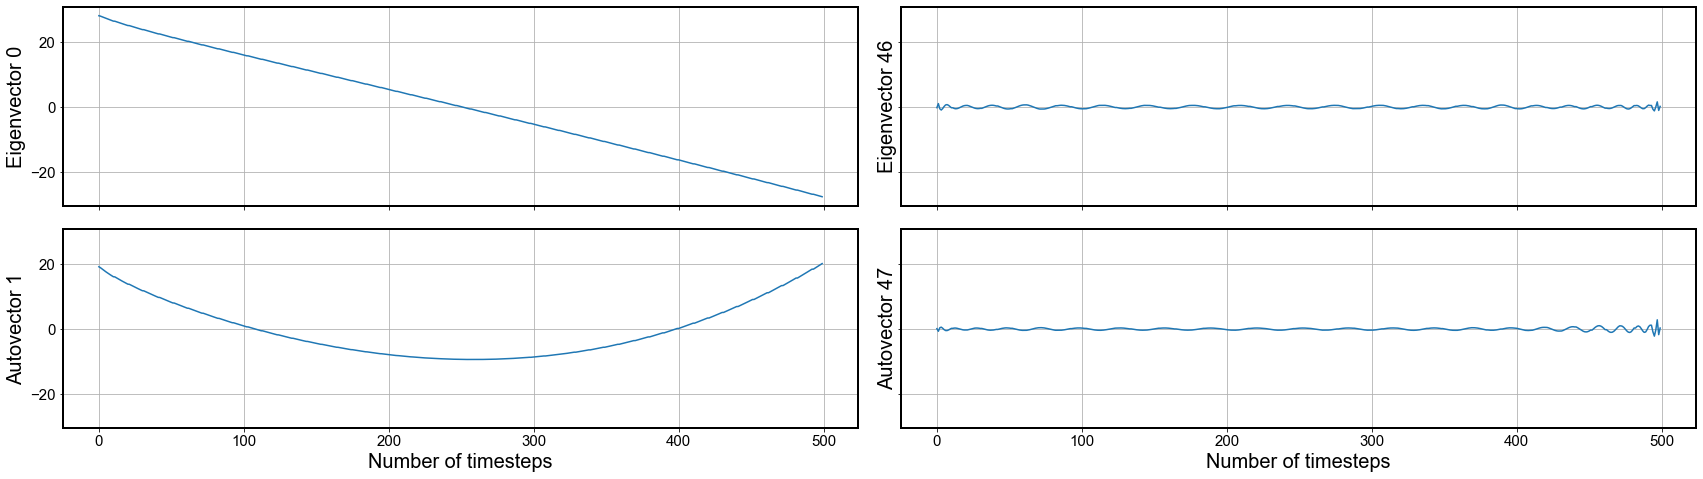

In [109]:
plot_samples(df)

The time series seem to be random values around 0. Is there some pattern in this data? If so, the selection of forecasting model would be easier.

We can see that the amplitude of the first few time series (which corresponds to the most important eigenvectors) have larger amplitude and lower frequency compared last eigenvectors (lower amplitude/energy and higher frequency).

# Statistical analysis of time series 

Statistical analysis has the objective of better understanding the behavior of our time series in order to better define our model

## Dickey-Fuller Test - visualize stationarity

This is the statistical test that we run to determine if a time series is stationary or not. Without going into the technicalities of the Dickey-Fuller test, it tests the null hypothesis that a unit root is present.

- If it is, then p > 0.05, and the process is not stationary.
- Otherwise, p < 0.05, the null hypothesis is rejected, and the process is considered to be stationary.

When the test statistic is lower than the critical value shown, you reject the null hypothesis and infer that the time series is stationary.

In [110]:
import statsmodels
from statsmodels.tsa.stattools import adfuller

In [111]:
# Augmented Dickey-Fuller Test

def ADF_test(timeseries, dataDesc):
    print(' > Is {} stationary?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='t-stat')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Lags used = {:.3f}'.format(dftest[2]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

for i in range(5):
    ADF_test(df[df.columns[i]],'Autovector ' + str(i))
    print('')

 > Is Autovector 0 stationary?
Test statistic = 6.270
P-value = 1.000
Lags used = 17.000
Critical values :
	1%: -3.4439899743408136 - The data is not stationary with 99% confidence
	5%: -2.8675550551408353 - The data is not stationary with 95% confidence
	10%: -2.569973792117904 - The data is not stationary with 90% confidence

 > Is Autovector 1 stationary?
Test statistic = 2.307
P-value = 0.999
Lags used = 18.000
Critical values :
	1%: -3.4440184853599876 - The data is not stationary with 99% confidence
	5%: -2.867567599912013 - The data is not stationary with 95% confidence
	10%: -2.5699804779975883 - The data is not stationary with 90% confidence

 > Is Autovector 2 stationary?
Test statistic = -2.706
P-value = 0.073
Lags used = 18.000
Critical values :
	1%: -3.4440184853599876 - The data is not stationary with 99% confidence
	5%: -2.867567599912013 - The data is not stationary with 95% confidence
	10%: -2.5699804779975883 - The data is  stationary with 90% confidence

 > Is Autove

In [112]:
# Visualizing stationarity for the least important eigenvectors
for i in range(5):
    ADF_test(df[df.columns[i+20]],'Autovector' + str(i+20))
    print('')

 > Is Autovector20 stationary?
Test statistic = -3.460
P-value = 0.009
Lags used = 18.000
Critical values :
	1%: -3.4440184853599876 - The data is  stationary with 99% confidence
	5%: -2.867567599912013 - The data is  stationary with 95% confidence
	10%: -2.5699804779975883 - The data is  stationary with 90% confidence

 > Is Autovector21 stationary?
Test statistic = -3.144
P-value = 0.023
Lags used = 18.000
Critical values :
	1%: -3.4440184853599876 - The data is not stationary with 99% confidence
	5%: -2.867567599912013 - The data is  stationary with 95% confidence
	10%: -2.5699804779975883 - The data is  stationary with 90% confidence

 > Is Autovector22 stationary?
Test statistic = -4.439
P-value = 0.000
Lags used = 14.000
Critical values :
	1%: -3.443905150512834 - The data is  stationary with 99% confidence
	5%: -2.867517732199813 - The data is  stationary with 95% confidence
	10%: -2.569953900520778 - The data is  stationary with 90% confidence

 > Is Autovector23 stationary?
Te

We can see that the first eigenvector are non stationary and exhibit a clear pattern while the last eigenvectors are stationary

## Detecting the presence of white noise

A time series can be summarized by the following formula:

y(t) = signal(t) + noise(t)

It is expected that a time series signal contains white noise. Therefore, it is an important concept for time series analysis to confirm if the signal has this for two main reasons:

- **Predictability:** if the time series is white noise, then it is, by definition, random. You cannot reasonably model it and make predictions
- **Model diagnostics:** The errors of a model should, ideally, be white noise. This means that all signal information in the time series has been harnessed by the model in order to make the predictions. If the model output is not white noise, it is an indication that further improvements can be made. 

The time series in not white noise if any of the following conditions are true:

- Time series have non-zero mean;
- The variance change over time;
- There exists correlation with lag values.

In [113]:
df.mean()

0     3.126388e-15
1     1.413980e-15
2     3.126388e-16
3    -1.001865e-15
4     2.319922e-15
5    -2.341238e-15
6     2.316369e-15
7    -2.593481e-16
8    -1.247003e-15
9    -7.212009e-16
10    4.249046e-15
11   -9.325873e-16
12   -1.616485e-16
13   -1.442402e-15
14   -1.254108e-15
15    2.557954e-16
16    2.662759e-15
17   -1.010747e-15
18   -1.121769e-15
19    4.568790e-15
20   -2.042810e-16
21   -2.129852e-15
22   -1.815437e-15
23   -1.518785e-16
24   -9.841017e-16
25    8.548717e-16
26   -1.123990e-15
27   -1.167955e-16
28    1.483258e-15
29   -2.735590e-16
30   -2.112976e-15
31   -1.861400e-15
32   -3.344880e-15
33    2.331912e-15
34   -6.830092e-16
35   -1.439737e-15
36   -7.118750e-16
37   -3.163025e-16
38   -8.681944e-17
39    2.055689e-15
40    8.613110e-16
41   -1.078915e-15
42    4.291401e-15
43    2.934319e-16
44   -1.893929e-15
45    3.810841e-16
46    2.662592e-15
47   -2.302936e-15
dtype: float64

The time series appear to all have zero mean. The standard deviation case is harder to do so lets avoid this for now and look at the lag values and visualize autocorrelation

In [114]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tqdm import tqdm

For random data, autocorrelations should be near zero for all lags. Analysts also refer to this condition as white noise. Non-random data have at least one significant lag. When the data are not random, it’s a good indication that you need to use a time series analysis or incorporate lags into a regression analysis to model the data appropriately. 

Looking again into stationarity, our signal must: 

- Not have a trend (mean=0);
- Have constant variance; 
- Have a constant autocorrelation pattern (below the confidence interval);
- Have no seasonal pattern. 

The autocorrelation function (ACF) declines to near zero rapidly for a stationary time series. For a non-stationary time series, the ACF drops slowly (our case takes 300 lags). There is also no seasonal components since there are no repetitive peaks in defined multiples. 

The confidence interval of 95% is represented by the shaded cone. Values outside the cone suggest very likely correlation and not a statistical fluke. Looks like only first lags have autocorrelation. 

Source: https://statisticsbyjim.com/time-series/autocorrelation-partial-autocorrelation/ 

Let us now take a closer look at the partial autocorrelation (PACF). Instead of finding correlations of present values with lags like ACF, PACF finds correlation of the residuals with the next lag. It is a function that measures the incremental benefit of adding another lag. So if through the PACF function we discover that there is hidden information in the residual that can be modeled by the next lag, we might get a good correlation, and we will keep that next lag as a feature while modeling.

As mentioned before, an autoregression is a model based on the assumption that present values of a time series can be obtained using previous values of the same time series: the present value is a
weighted average of its past values. In order to avoid multicollinear features for time series models, it is necessary to find optimum features or order of the autoregression process using the PACF
plot, as it removes variations explained by earlier lags, so we get only the relevant features.

100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


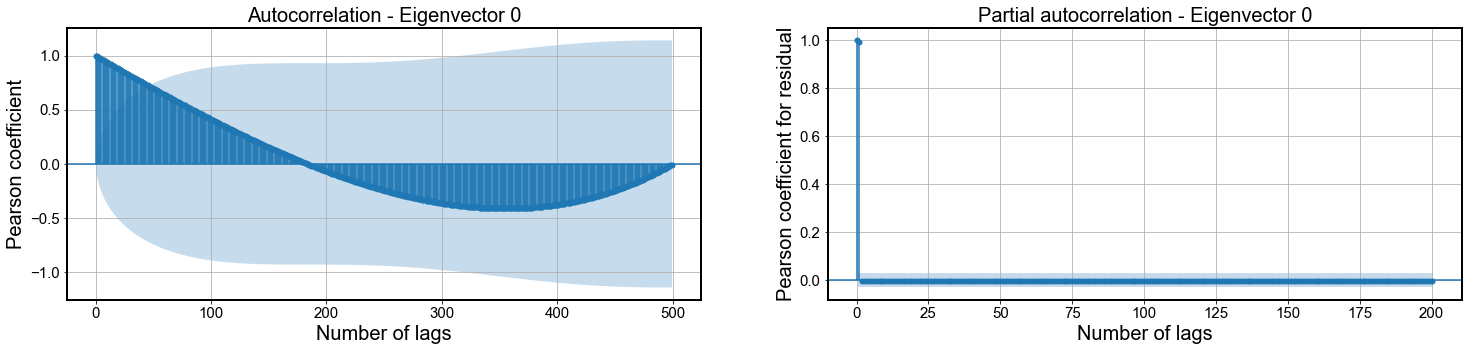

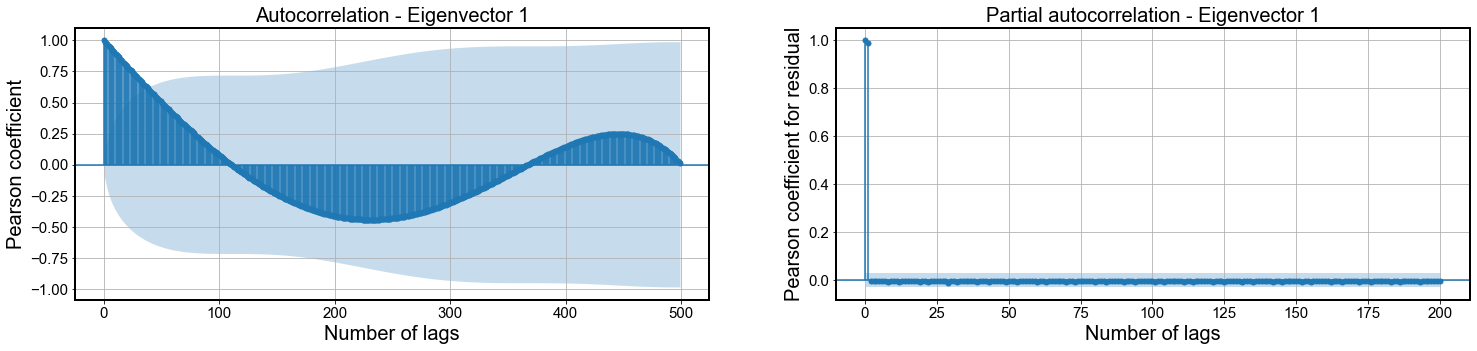

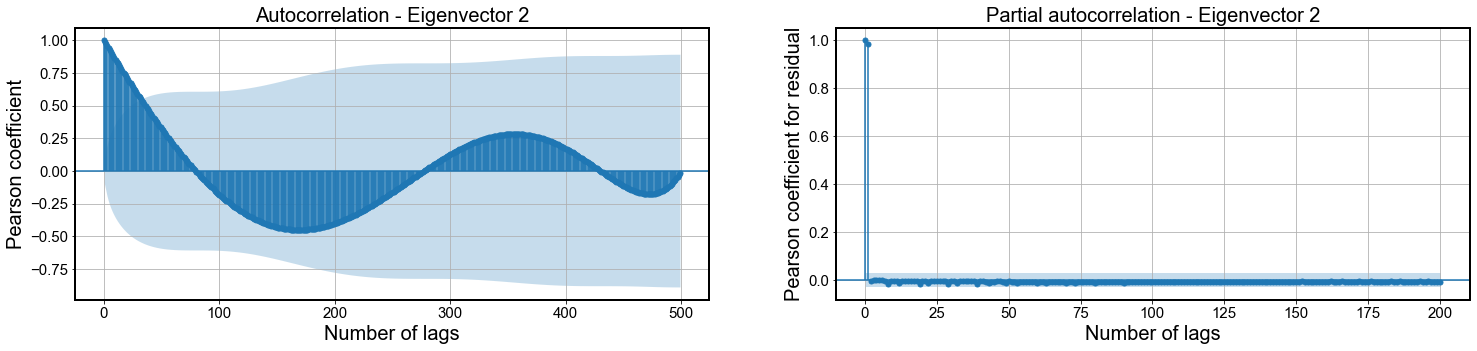

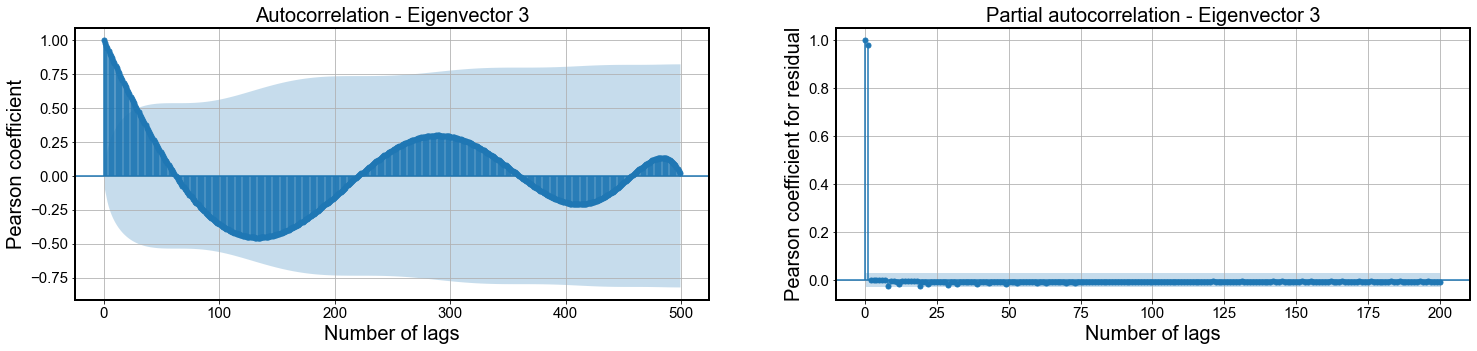

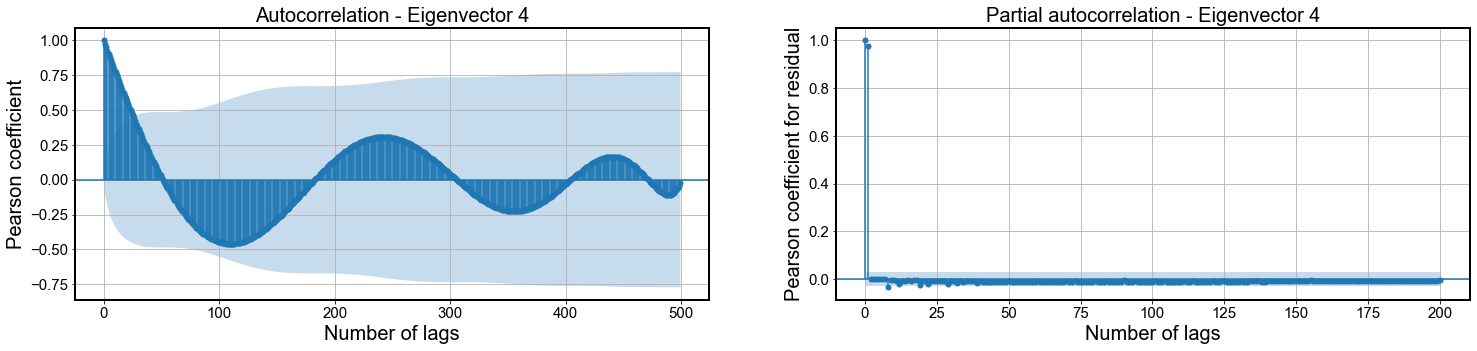

In [115]:
for i in tqdm(range(5)):
    plot_autocorrelation(df,i)

100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


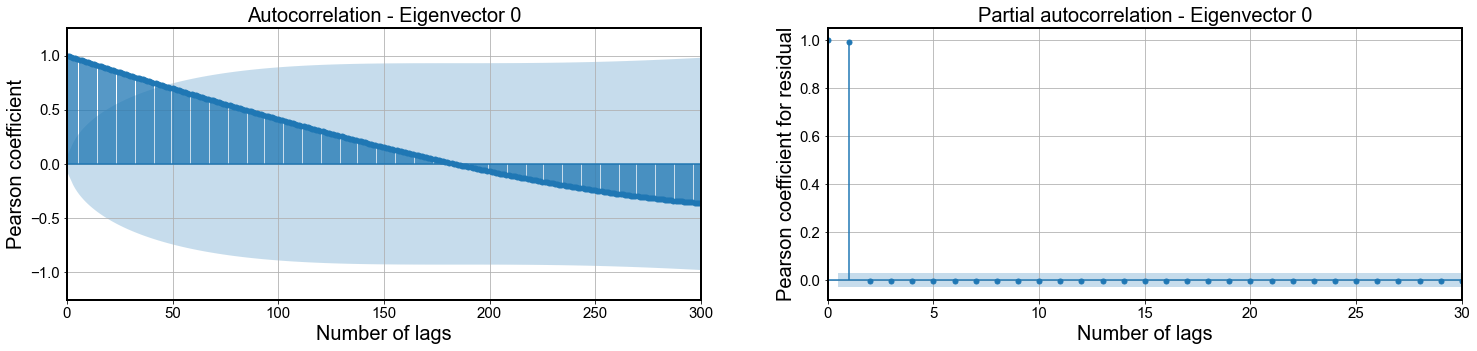

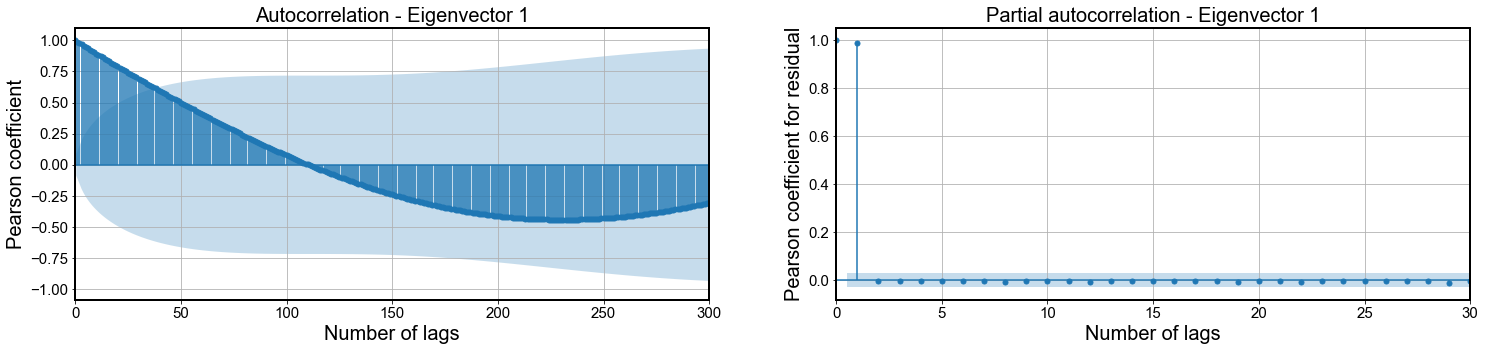

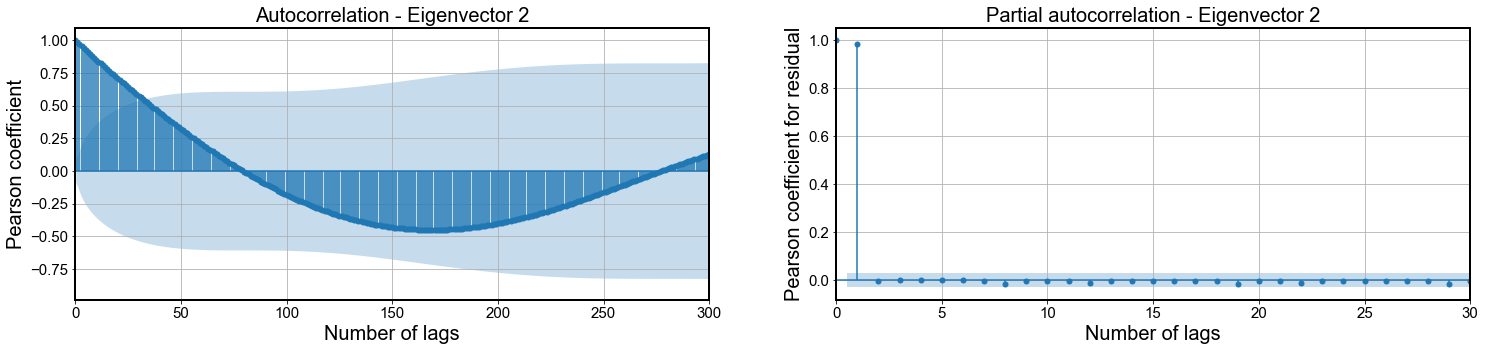

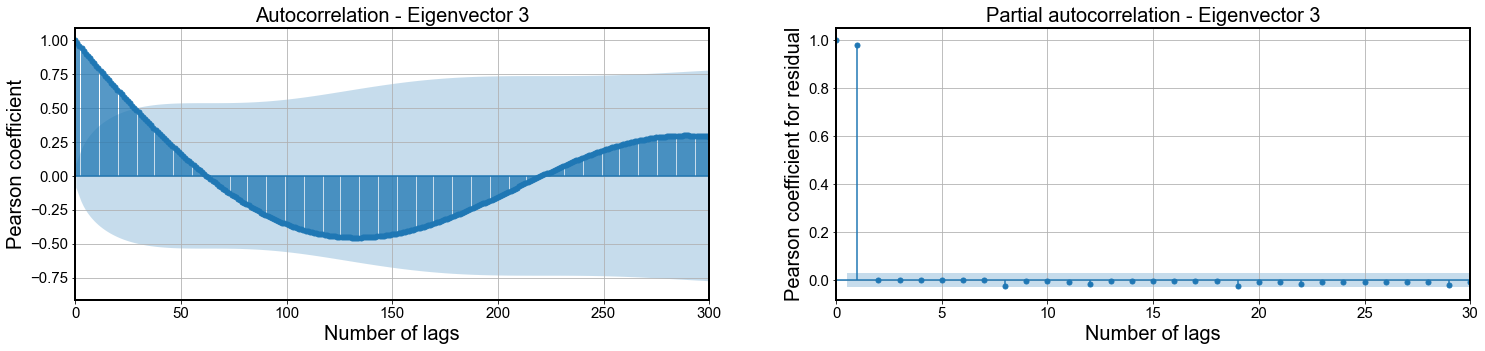

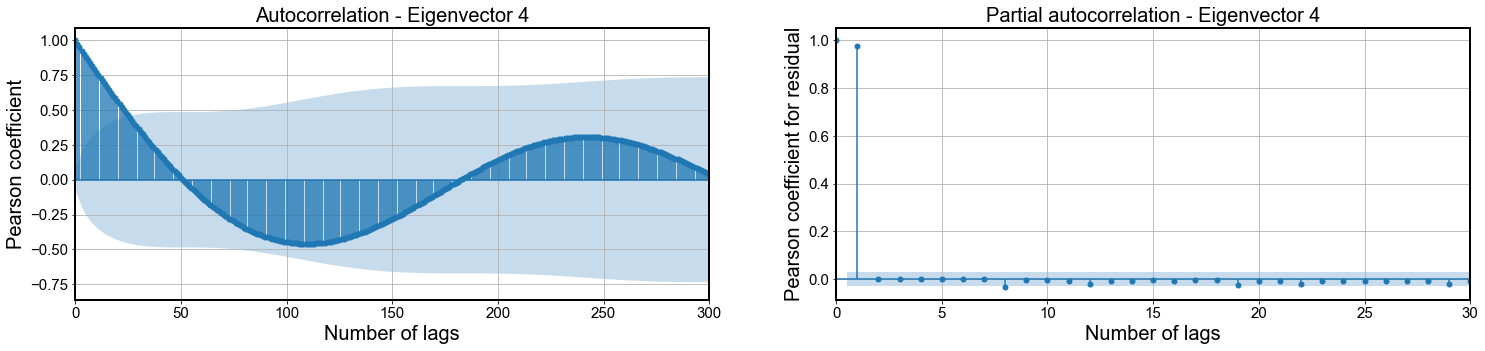

In [116]:
for i in tqdm(range(5)):
    plot_autocorrelation(df,i,zoom=True)

100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


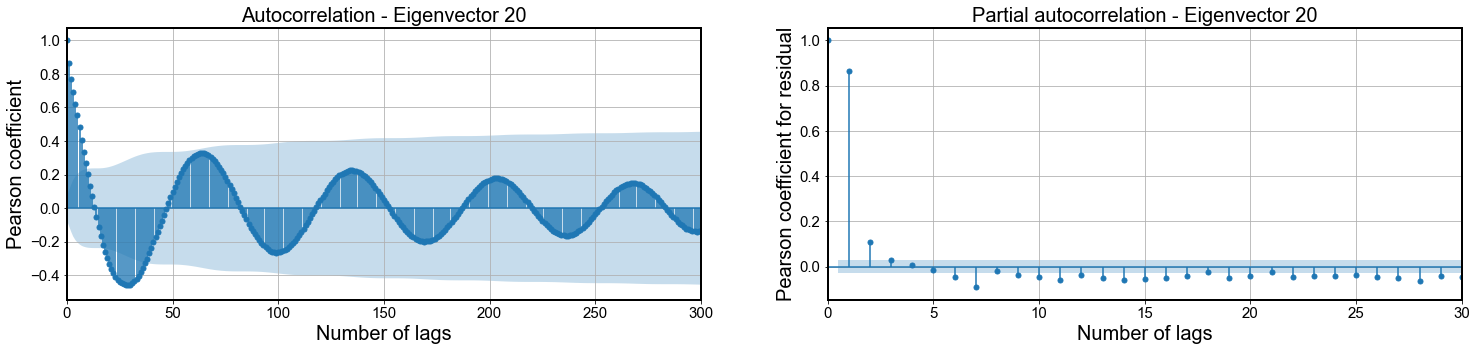

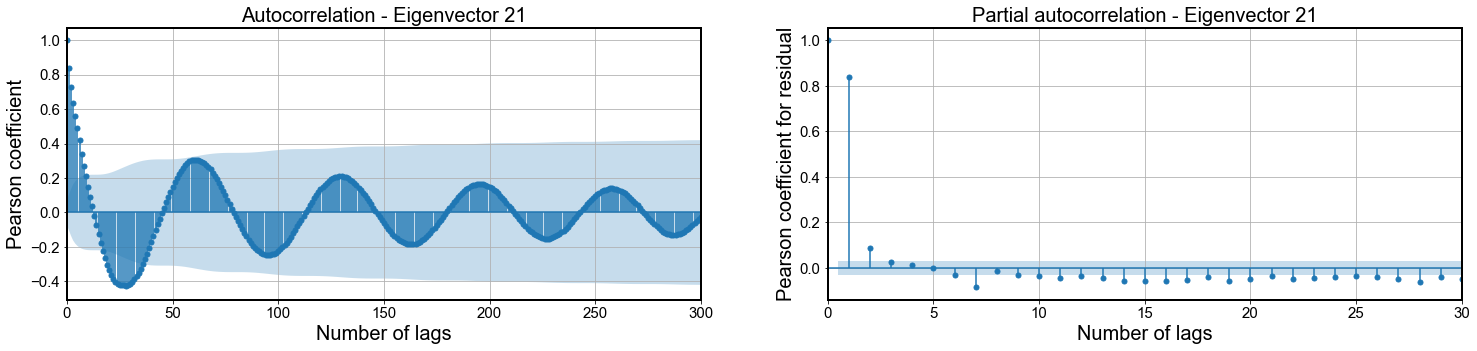

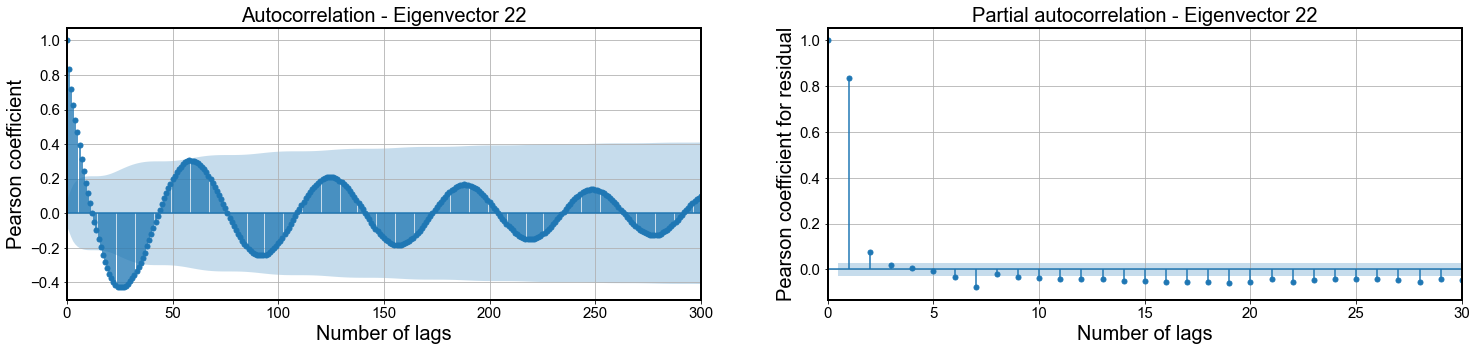

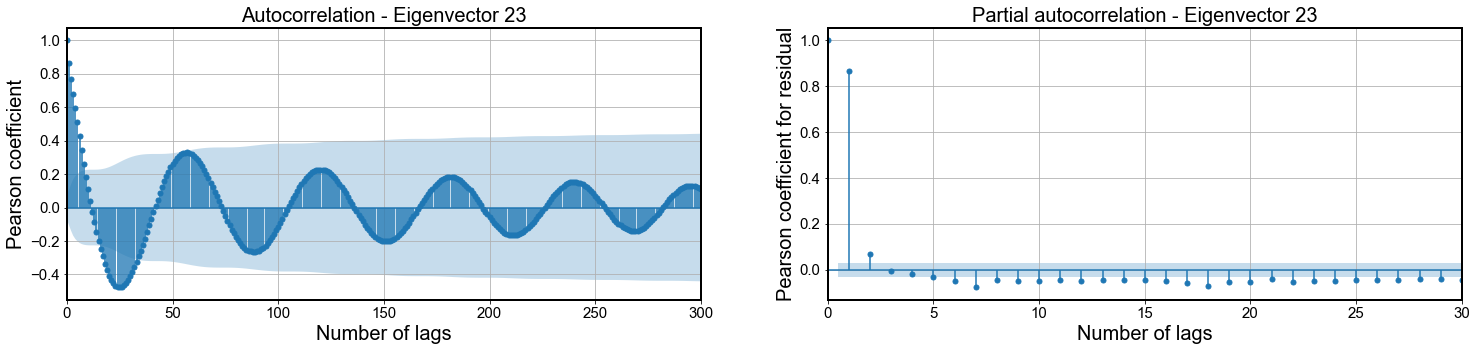

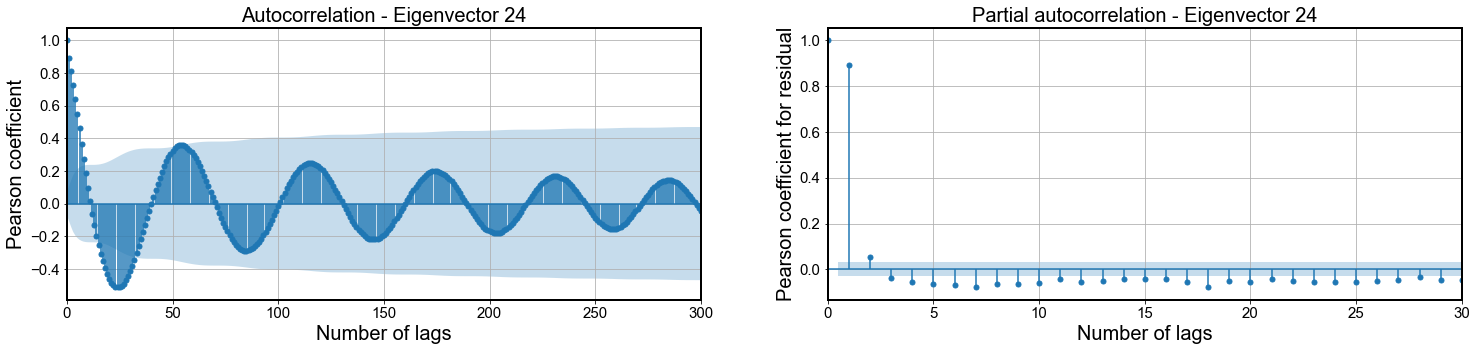

In [117]:
for i in tqdm(range(5)):
    plot_autocorrelation(df,i+20,zoom=True) # Last eigenvectors

From the partial autocorrelation plots, the most extreme lag that can be used a predictor would lag 1 based on the Pearson coefficient. 

There is clear seasonality present here and could be modeled better traditional statistical models like SARIMA.

Source: 
- https://www.linkedin.com/pulse/how-use-machine-learning-time-series-forecasting-vegard-flovik-phd-1f/
- https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424
- Book: Machine learning for time series forecasting with Python - Francesca Lazzeri (for explaining PACF and ACF)
- https://stats.stackexchange.com/questions/226468/how-many-lags-should-i-include-in-time-series-prediction 

# Creating the dataset for typical ML models

We must frame our time series forecasting problem as a supervised learning problem. Given an input dataset **X** and an output variable **y**, we will try to find a mapping function from the input to the output. This involves using past and present values to obtain future values.

To do so, our dataset **X** must be the data at present and previous time step while **y** must be the data at the next time step. The order between observations must be preserved due to the observed dependency with past values. 

The definition of "next time step" must also be studied. Should we forecast one step into the future? Maybe the model is still accurate for 41 time steps into the future? Who nows? We must test this to see when model accuracy starts to drop.

Note that we are working with a **multivariate time series**, meaning that two or more variables (eigenvectors in this case) are observed at each time. In this specific case, we are working with PCA components. Due to their property of orthogonality, each of the 93 eigenvector time series are linearly independent (uncorrelated) with one another. This is a necessary condition for independence, but not a sufficient condition since higher order dependence may exist. We assume that the orthogonality is sufficient to state that the time series are independent, especially since we are dealing with a chaotic system


## Now actually creating the dataset

In [118]:
def create_dataset(df,series_column_name,nlags=5,HORIZON=50):
    df_series = pd.DataFrame(df[series_column_name]) # Selecting one time series from the dataframe
    df_series.columns=['t']
    
    for k in range(1,nlags): # Create input dataset with lagged features
        label = 'Lag_' + str(k)
        df_series[label] = df_series['t'].shift(k) # lag column of value k
    
    
    df_series['Forecast_' + str(HORIZON-1)] = df_series['t'].shift(-HORIZON)
    
    df_series.dropna(inplace=True)
    return df_series

NLAGS = 2
HORIZON=10
EIGENVECTOR_NUMBER = 1
dataframe = create_dataset(df,EIGENVECTOR_NUMBER,nlags=NLAGS,HORIZON=HORIZON)
dataframe

,t,Lag_1,Forecast_9
1,19.029829,19.296020,16.162490
2,18.687182,19.029829,15.897243
3,18.341167,18.687182,15.634105
4,18.004644,18.341167,15.375664
5,17.681726,18.004644,15.120961
...,...,...,...
485,16.610071,16.338889,19.118605
486,16.881673,16.610071,19.404700
487,17.156101,16.881673,19.693332
488,17.431408,17.156101,19.982786


In [119]:
dataframe_train = dataframe[:450]
dataframe_test = dataframe[450:]
print('Training dataframe shape: ', dataframe_train.shape)
print('Test dataframe shape: ', dataframe_test.shape) 

Training dataframe shape:  (450, 3)
Test dataframe shape:  (39, 3)


In [120]:
dataframe_train

,t,Lag_1,Forecast_9
1,19.029829,19.296020,16.162490
2,18.687182,19.029829,15.897243
3,18.341167,18.687182,15.634105
4,18.004644,18.341167,15.375664
5,17.681726,18.004644,15.120961
...,...,...,...
446,8.051533,7.834608,10.071781
447,8.270418,8.051533,10.303511
448,8.488783,8.270418,10.535517
449,8.709547,8.488783,10.772359


Illustrating the forecasting problem

Text(0.5, 0, 'Number of time steps')

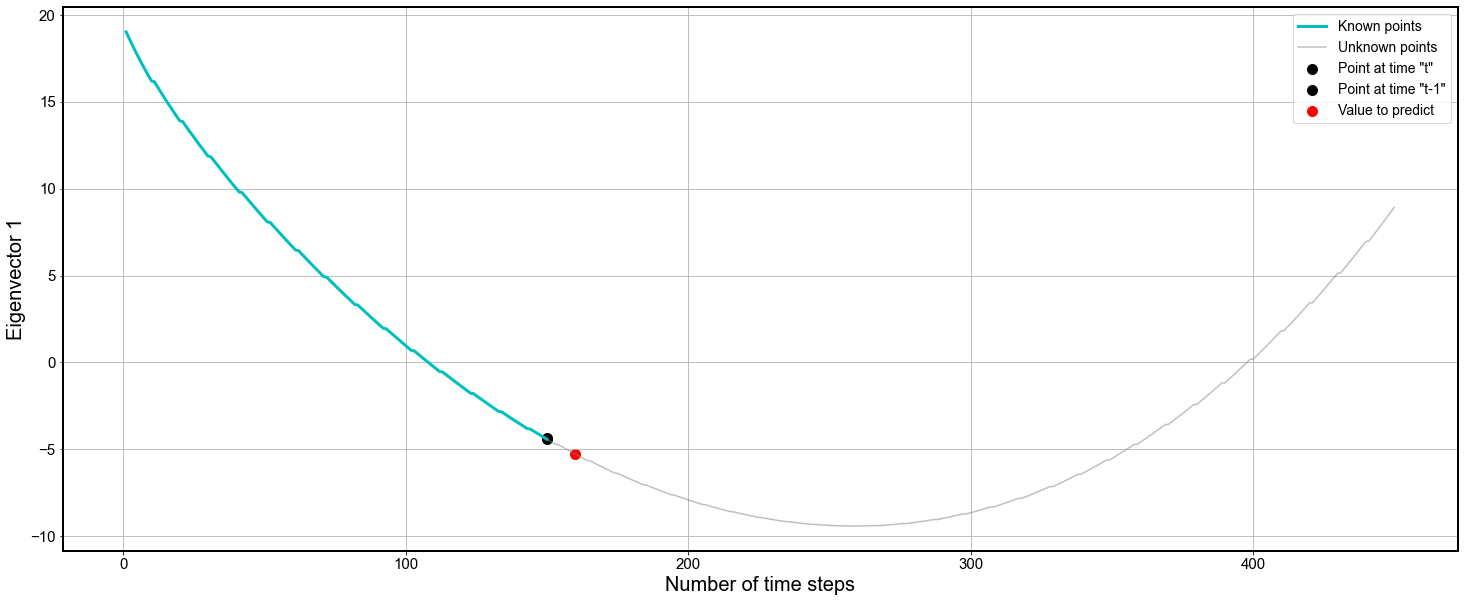

In [121]:
id2 = 300
id1 = 150
known = dataframe_train['t'].loc[0:id1] 
unknown = dataframe_train['t'].loc[id1:len(dataframe)] 
to_predict = dataframe_train['Forecast_9'].loc[id1]

feat1 = dataframe_train['t'].loc[id1]
feat2 = dataframe_train['Lag_1'].loc[id1]  

fig, ax = plt.subplots()


plt.scatter(id1,feat1, c='k', marker='o',label = 'Point at time "t"')
plt.scatter(id1,feat2, c='k', marker='o',label = 'Point at time "t-1"')
plt.scatter(id1+HORIZON,to_predict, c='r', marker='o',label = 'Value to predict')


known.plot(ax=ax, c='c', label = 'Known points',linewidth=3)
unknown.plot(ax=ax, c='grey', alpha=0.5,label = 'Unknown points')


ax.legend()
ax.set_ylabel('Eigenvector {}'.format(EIGENVECTOR_NUMBER))
ax.set_xlabel('Number of time steps')

# Training traditional ML algorithms - test 1

PyCaret Regression Module is a supervised machine learning module used for estimating the relationships between a dependent variable (often called the ‘outcome variable’, or ‘target’) and one or more independent variables (often called ‘features’, or ‘predictors’).

In [122]:
dataframe

,t,Lag_1,Forecast_9
1,19.029829,19.296020,16.162490
2,18.687182,19.029829,15.897243
3,18.341167,18.687182,15.634105
4,18.004644,18.341167,15.375664
5,17.681726,18.004644,15.120961
...,...,...,...
485,16.610071,16.338889,19.118605
486,16.881673,16.610071,19.404700
487,17.156101,16.881673,19.693332
488,17.431408,17.156101,19.982786


In [123]:
from pycaret.regression import *

clf1 = setup(data = dataframe,
             #test_data = dataframe_test, 
             target = dataframe.columns[-1], 
             data_split_shuffle = False,
             use_gpu = True,
             fold_strategy = 'timeseries',
             preprocess = False,
             #polynomial_features = True,
             #polynomial_degree = 2,
             fold = 5,
             silent=True,
             session_id = 123) # testing for predicting one time series

,Description,Value
0,session_id,123
1,Target,Forecast_9
2,Original Data,"(489, 3)"
3,Missing Values,False
4,Numeric Features,2
5,Categorical Features,0
6,Transformed Train Set,"(342, 2)"
7,Transformed Test Set,"(147, 2)"
8,Shuffle Train-Test,False
9,Stratify Train-Test,False


In [124]:
models() # display models used by pycaret

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


### Training the models 

In [125]:
# Training all models from the above list with the exception of three and get the best 3
top = compare_models(sort = 'MAE',
                      exclude = ['lar','par','llar'],
                      round = 3,
                      n_select = 3) 

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,0.211,0.076,0.235,-0.684,0.042,0.231,0.012
lr,Linear Regression,0.321,0.173,0.338,-0.569,0.061,0.313,0.004
br,Bayesian Ridge,0.323,0.175,0.340,-0.582,0.061,0.317,0.006
omp,Orthogonal Matching Pursuit,0.368,0.248,0.387,-0.774,0.067,0.329,0.004
ridge,Ridge Regression,0.378,0.255,0.397,-0.870,0.070,0.360,0.004
en,Elastic Net,0.502,0.389,0.524,-0.246,0.120,0.962,0.006
lasso,Lasso Regression,0.553,0.483,0.579,0.018,0.136,1.228,0.006
et,Extra Trees Regressor,1.882,6.815,2.105,-2.343,0.409,4.976,0.534
dt,Decision Tree Regressor,1.885,6.823,2.109,-2.350,0.410,4.976,0.004
gbr,Gradient Boosting Regressor,1.886,6.829,2.110,-2.366,0.410,4.978,0.028


In [130]:
# generate predictions for the entire dataset
predictions = predict_model(top[0], data=dataframe)
predictions['time_step'] = predictions.index - predictions.index.min() + 1
predictions

,t,Lag_1,Forecast_9,Label,time_step
1,19.029829,19.296020,16.162490,16.673818,1
2,18.687182,19.029829,15.897243,15.633819,2
3,18.341167,18.687182,15.634105,15.256664,3
4,18.004644,18.341167,15.375664,15.006208,4
5,17.681726,18.004644,15.120961,14.806875,5
...,...,...,...,...,...
485,16.610071,16.338889,19.118605,19.149040,485
486,16.881673,16.610071,19.404700,19.424843,486
487,17.156101,16.881673,19.693332,19.725380,487
488,17.431408,17.156101,19.982786,20.009064,488


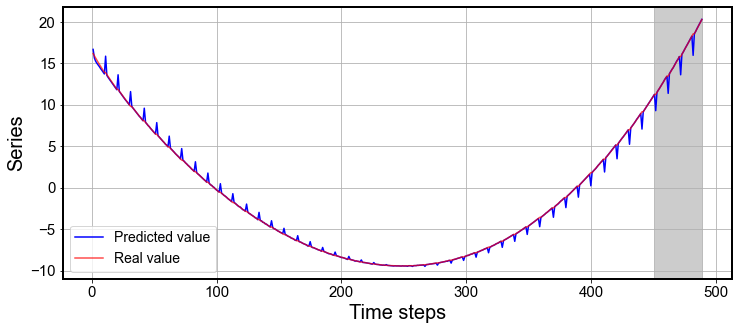

In [131]:
plt.figure(figsize=(12,5))
plt.plot(predictions.time_step,predictions['Label'],color='blue',label='Predicted value')
plt.plot(predictions.time_step,predictions[dataframe.columns[-1]],color='red',alpha=0.7,label='Real value')
plt.xlabel('Time steps')
plt.ylabel('Series')
plt.legend()

# add a vertical rectange for test-set separation
plt.axvspan(xmin=dataframe_test.index[0], xmax = dataframe_test.index[-1],color='grey',alpha=0.4)

For these eigenvectors with a clear behaviour, the machine learning model has difficulties in finding the pattern. This is largely due to the model and not the time series.

The can easily be corrected by manually checking the eigenvectors for the ones with clear patterns and find the optimal model for them.

# Training all time series

In [132]:
all_results = [] # Save the MAE result for each HORIZON value to determine how far we can forecast
final_model = {}

def train_all_time_series(df,nlags,HORIZON):

    for i in tqdm(range(len(df.columns))):
        dataframe = create_dataset(df,i,nlags=NLAGS,HORIZON=HORIZON) 

        s = setup(data = dataframe,
                     #test_data = dataframe_test, 
                     target = dataframe.columns[-1], 
                     data_split_shuffle = False,
                     use_gpu = True,
                     fold_strategy = 'timeseries',
                     preprocess = False,
                     fold = 5,
                     silent=True,
                     session_id = 123,
                     verbose=False) # testing for predicting one time series
        
    # Teste and compare different ML models
        best_model = compare_models(sort = 'MAE',
                                    exclude=['lar','ada','llar','rf','gbr','dt'],
                                    n_select = 1,
                                    verbose=False) 
    
    # Hyperparameter tuning with optuna 
        #best_model_tuned = tune_model(best_model, 
        #                              n_iter = 100,
        #                              search_library='optuna',
        #                              #search_algorithm='tpe',
        #                              optimize = 'MAE',
        #                              verbose=False,
        #                              choose_better=True)
    
    
        # capture the compare result grid and store best model in list
        p = pull().iloc[0:1]
        p['time_series'] = str(i)
        all_results.append(p)
    
        f = finalize_model(best_model) # finalize model i.e fit on entire dataset including test set
        final_model[i] = f # Attach final model to a dictionary
        save_model(f, model_name='trained_models_Buckley/' + str(i), verbose=False) # pickle the trained model into this folder
    
# Source: https://towardsdatascience.com/multiple-time-series-forecasting-with-pycaret-bc0a779a22fe 

In [133]:
NLAGS = NLAGS # From analyzing the PACF plot, this value was chosen. 
HORIZON = HORIZON # Predict `HORIZON` time steps into the future
train_all_time_series(df,nlags=NLAGS,HORIZON=HORIZON)

# https://www.youtube.com/watch?v=_ZQ-lQrK9Rg&ab_channel=CodeEmporium 

100%|██████████| 48/48 [10:12<00:00, 12.76s/it]


In [134]:
# Display the best model selected for each time series.

concat_results = pd.concat(all_results,axis=0)
concat_results.head(10)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec),time_series
huber,Huber Regressor,0.0992,0.0132,0.1063,0.9958,0.0166,0.0411,0.010,0
huber,Huber Regressor,0.2109,0.0757,0.2346,-0.6839,0.0421,0.2313,0.012,1
huber,Huber Regressor,0.1903,0.0916,0.2669,-0.5374,0.0574,0.0597,0.010,2
huber,Huber Regressor,0.2330,0.1203,0.3080,0.0318,0.0871,0.3525,0.010,3
huber,Huber Regressor,0.4284,0.5146,0.5030,0.6150,0.1541,0.3370,0.010,4
huber,Huber Regressor,0.3468,0.1986,0.3966,0.6765,0.1636,0.6616,0.008,5
huber,Huber Regressor,0.3006,0.1346,0.3519,0.7769,0.1405,0.3813,0.008,6
huber,Huber Regressor,0.3652,0.1954,0.4112,0.6109,0.1712,0.5920,0.008,7
huber,Huber Regressor,0.3997,0.2373,0.4534,0.4357,0.2060,0.7885,0.008,8
huber,Huber Regressor,0.3995,0.2576,0.4515,0.7328,0.2077,0.7595,0.008,9


In [135]:
concat_results.tail(10)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec),time_series
knn,K Neighbors Regressor,0.2010,0.0845,0.2635,0.5449,0.1440,1.5036,0.020,38
knn,K Neighbors Regressor,0.1665,0.0577,0.2236,0.5433,0.1295,1.3991,0.022,39
knn,K Neighbors Regressor,0.1774,0.0682,0.2435,0.5784,0.1373,2.0378,0.022,40
knn,K Neighbors Regressor,0.1610,0.0539,0.2188,0.6855,0.1338,1.1476,0.020,41
et,Extra Trees Regressor,0.1385,0.0377,0.1868,0.7502,0.1162,0.9295,0.526,42
knn,K Neighbors Regressor,0.1286,0.0347,0.1763,0.7020,0.1166,1.0207,0.022,43
et,Extra Trees Regressor,0.1001,0.0196,0.1329,0.6956,0.0850,1.2052,0.522,44
knn,K Neighbors Regressor,0.1518,0.0470,0.1986,0.6464,0.1224,2.7188,0.022,45
et,Extra Trees Regressor,0.1773,0.0558,0.2265,0.6230,0.1439,1.6870,0.524,46
knn,K Neighbors Regressor,0.1083,0.0206,0.1388,0.6738,0.0885,1.0400,0.020,47


Text(0.5, 1.0, 'Forecasting R^2 for each time series - Horizon=80')

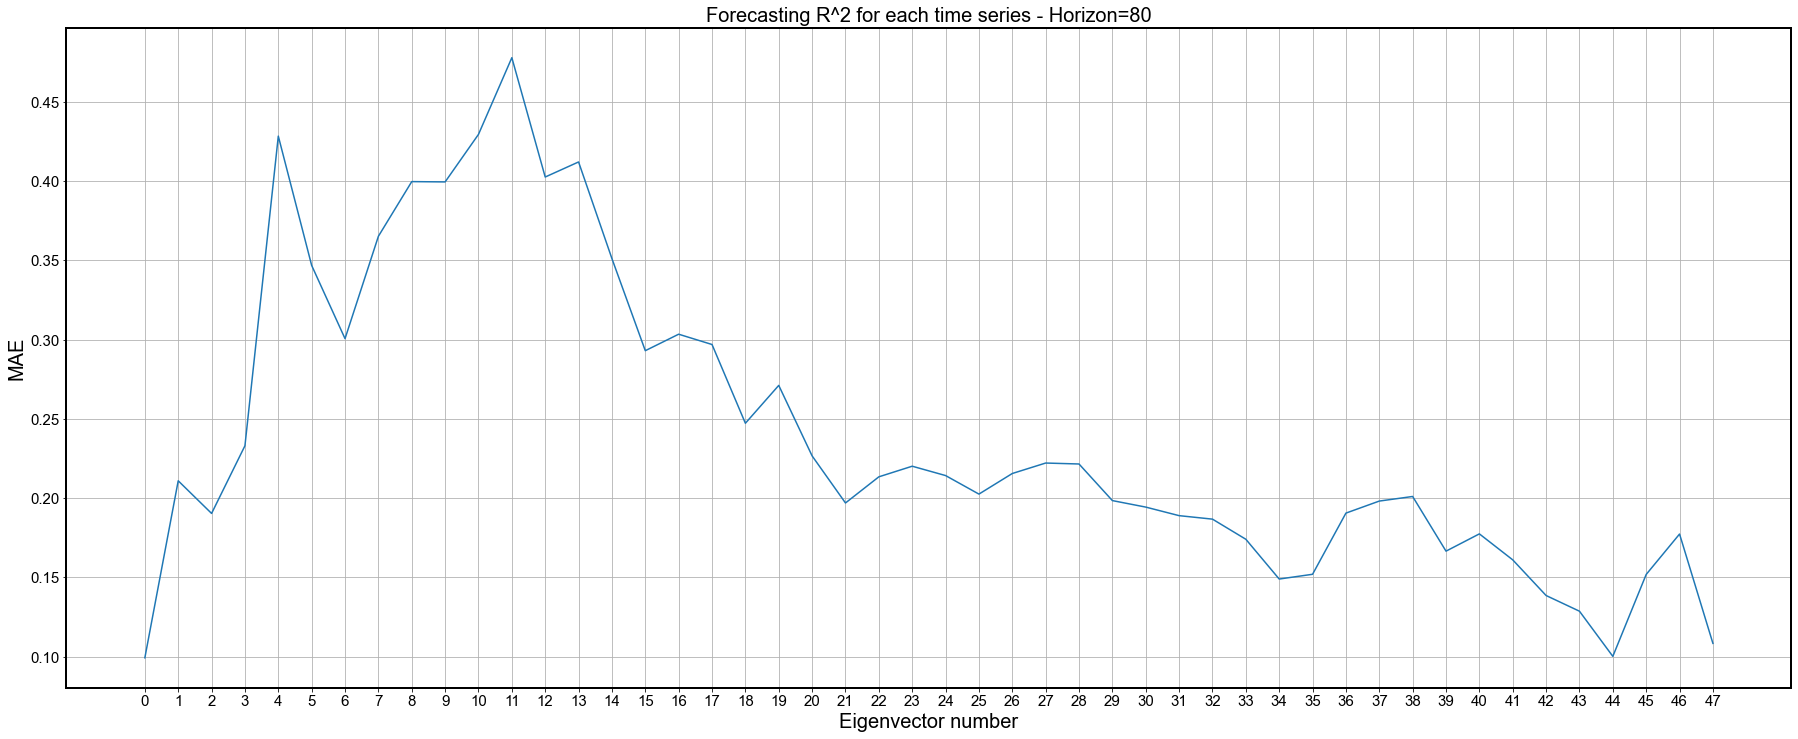

In [136]:
plt.plot(concat_results['time_series'],concat_results['MAE'])
plt.tight_layout()
plt.ylabel('MAE')
plt.xlabel('Eigenvector number')
plt.title('Forecasting R^2 for each time series - Horizon=80')

Traditional ML models have an easier time fitting the first eigenvectors compared to the last eigenvectors. This is due to three main reasons:

-  The last eigenvectors have larger frequency compared to the first. The trained models have dificulty in accuratly fitting these sudden changes
-  Looking at the forecasting horizon figure above for eigenvector 1, we see that the horizon window of 80 and the last known point (in blue) can be approximated well by a line. This coincides with the best performing models that Pycaret being linear. Therefore, the first eigenvectors have good results due to the forecasting horizon. 
-  For the last eigenvectors, the faster frequency makes it so that the relationship cannot be approximated so well by linear functions. This is responsible for the worse results. A better overall performance can be obtained by decreasing the forecasting horizon. In this case, the performance of the first eigenvectors will be the same, but the last eigenvectors will be substantially better.

Here is an interesting point to think about. If the last eigenvectors are the least important, should we really care that much about their forecasting being bad?

Let us see if this actually affects the final results

In [137]:
# Now let’s create a loop to load the trained pipelines and use the predict_model function to generate prediction labels.

all_score_df = []

for i in tqdm(range(df.shape[1])):
    l = load_model('trained_models_Buckley/' + str(i), verbose=False)
    
    dataframe = create_dataset(df,i,nlags=NLAGS,HORIZON=HORIZON)       
    p = predict_model(l, data=dataframe)
    all_score_df.append(p)

concat_df = pd.concat(all_score_df, axis=1)
print(concat_df.shape)
concat_df.head(10)

100%|██████████| 48/48 [00:19<00:00,  2.43it/s]

(489, 192)


,t,Lag_1,Forecast_9,Label,t,Lag_1,Forecast_9,Label,t,Lag_1,...,Forecast_9,Label,t,Lag_1,Forecast_9,Label,t,Lag_1,Forecast_9,Label
1,28.159211,28.272552,26.576760,27.103992,19.029829,19.296020,16.162490,16.671198,-14.990199,-15.442553,...,0.054815,0.042677,1.061976,-0.202646,-0.234419,-0.234419,-0.678755,0.123973,0.223273,0.966278
2,27.981989,28.159211,26.422566,26.922460,18.687182,19.029829,15.897243,15.632605,-14.471222,-14.990199,...,0.443235,-0.312403,-0.540728,1.061976,-0.446495,-0.446495,0.394791,-0.678755,0.306726,-0.126331
3,27.799445,27.981989,26.268850,26.739318,18.341167,18.687182,15.634105,15.255624,-13.970790,-14.471222,...,0.698616,-0.177389,-0.925490,-0.540728,-0.531593,-0.531593,0.596923,0.394791,0.308976,-0.468282
4,27.619265,27.799445,26.116652,26.559029,18.004644,18.341167,15.375664,15.005121,-13.496280,-13.970790,...,0.769742,-0.024484,-0.463062,-0.925490,-0.478828,-0.478828,0.250506,0.596923,0.228687,-0.029823
5,27.441179,27.619265,25.965893,26.380822,17.681726,18.004644,15.120961,14.805668,-13.041373,-13.496280,...,0.681320,0.034813,0.182414,-0.463062,-0.330183,-0.330183,-0.184332,0.250506,0.109164,0.366479
6,27.267179,27.441179,25.817463,26.206833,17.369919,17.681726,14.871821,14.594638,-12.609365,-13.041373,...,0.450607,-0.029052,0.646473,0.182414,-0.113422,-0.113422,-0.453965,-0.184332,-0.032135,0.451200
7,27.095790,27.267179,25.670250,26.035365,17.065709,17.369919,14.626121,14.359248,-12.192390,-12.609365,...,0.154755,0.508750,0.747297,0.646473,0.116157,0.116157,-0.465869,-0.453965,-0.157775,0.349554
8,26.927790,27.095790,25.523878,25.867338,16.771488,17.065709,14.382862,14.155636,-11.791286,-12.192390,...,-0.149656,0.547662,0.539401,0.747297,0.309750,0.309750,-0.293038,-0.465869,-0.244565,0.244847
9,26.762279,26.927790,25.378183,25.701750,16.483622,16.771488,14.142091,13.925292,-11.402727,-11.791286,...,-0.421261,-0.293608,0.164646,0.539401,0.440120,0.440120,-0.031772,-0.293038,-0.288214,-0.110673
10,26.599748,26.762279,25.234123,25.539175,16.203391,16.483622,13.905390,13.714251,-11.026989,-11.402727,...,-0.616823,-0.214902,-0.221058,0.164646,0.490591,0.490591,0.212771,-0.031772,-0.276713,-0.100854


100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


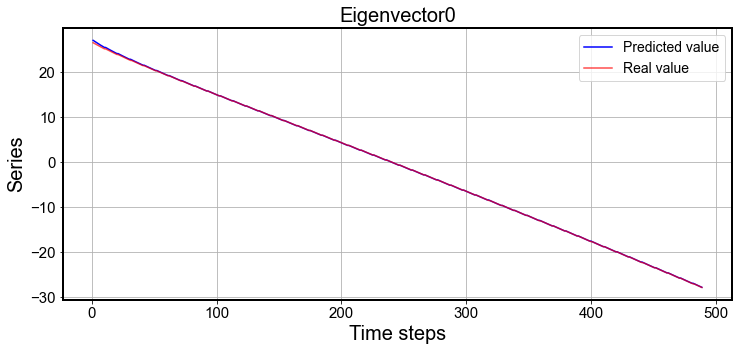

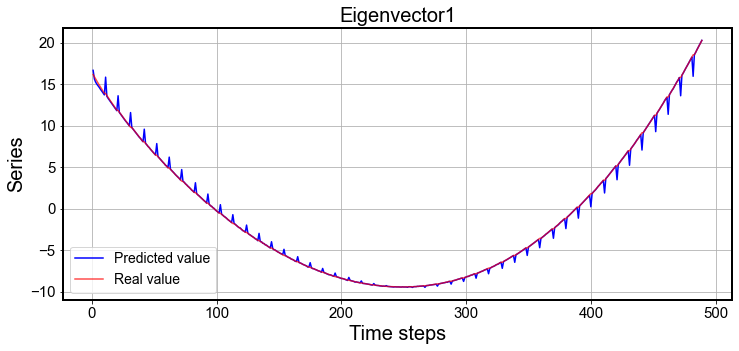

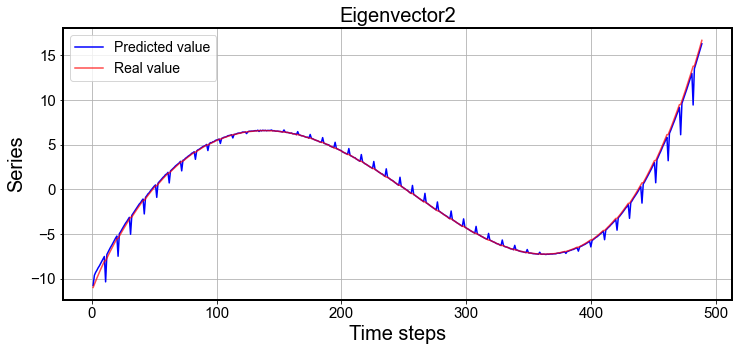

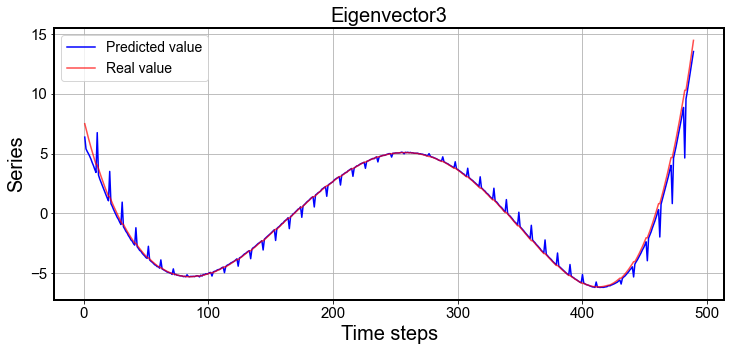

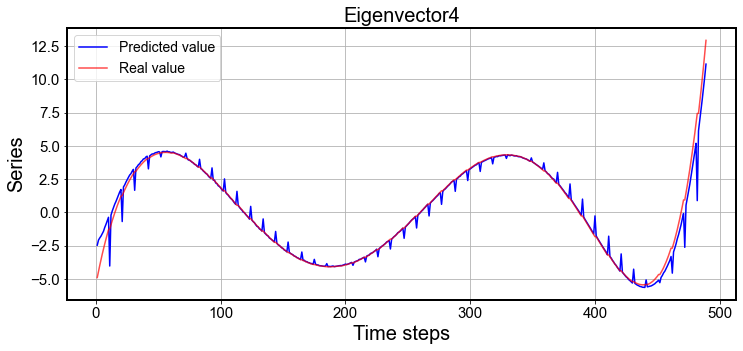

In [138]:
# Plot comparison for test dataset - first eigenvectors

for i in tqdm(range(5)):
    
    l = load_model('trained_models_Buckley/' + str(i), verbose=False)
    
    dataframe = create_dataset(df,i,nlags=NLAGS,HORIZON=HORIZON)  
    p = predict_model(l, data=dataframe)
    
    plt.figure(figsize=(12,5))
    
    plt.plot(p['Label'],color='blue',label='Predicted value')
    plt.plot(p[dataframe.columns[-1]],color='red',alpha=0.7,label='Real value')
    
    plt.title('Eigenvector' + str(i))
    plt.xlabel('Time steps')
    plt.ylabel('Series')
    plt.legend()

100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


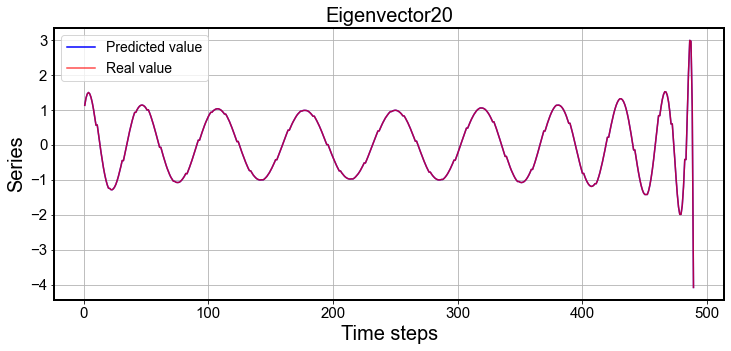

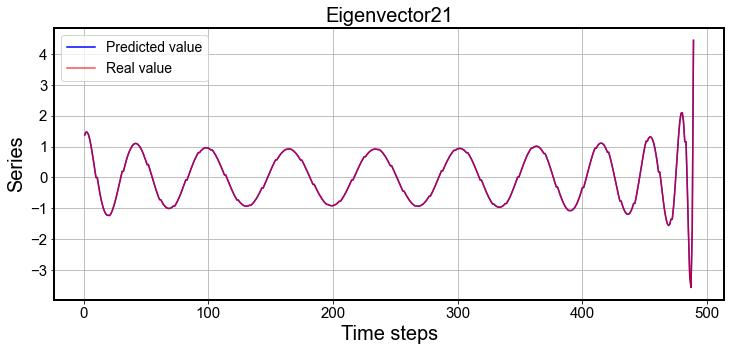

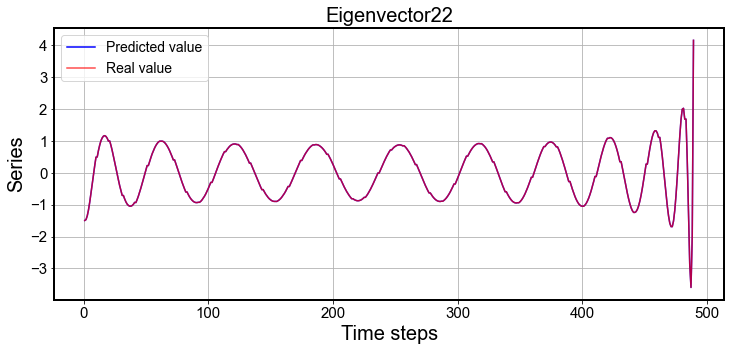

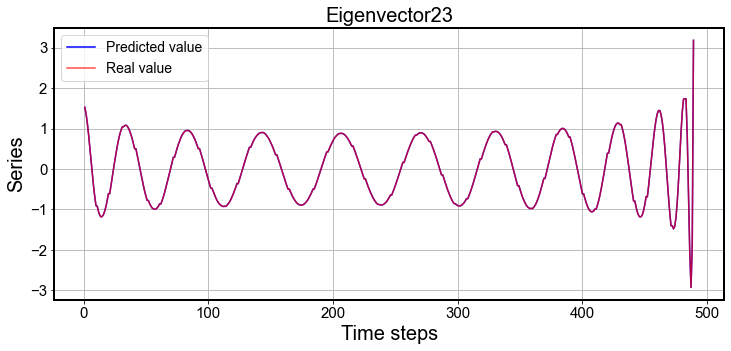

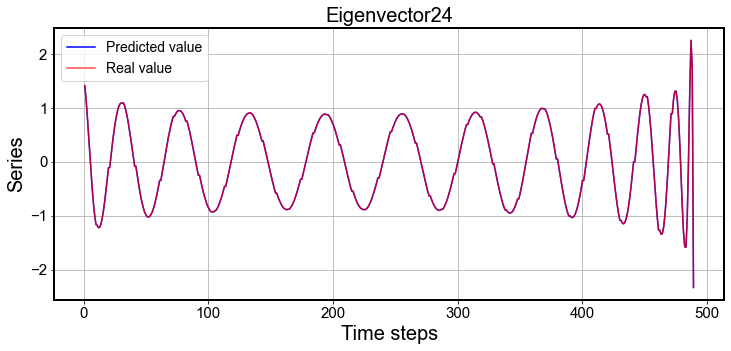

In [139]:
for i in tqdm(range(5)):
    
    i=i+20
    l = load_model('trained_models_Buckley/' + str(i), verbose=False)
    
    dataframe = create_dataset(df,i,nlags=NLAGS,HORIZON=HORIZON)  
    p = predict_model(l, data=dataframe)
    
    plt.figure(figsize=(12,5))
    
    plt.plot(p['Label'],color='blue',label='Predicted value')
    plt.plot(p[dataframe.columns[-1]],color='red',alpha=0.7,label='Real value')
    
    plt.title('Eigenvector' + str(i))
    plt.xlabel('Time steps')
    plt.ylabel('Series')
    plt.legend()

In [140]:
predicted_time_series = concat_df.loc[:,concat_df.columns == 'Label']
print(predicted_time_series.shape)
predicted_time_series.columns = ['Eigenvector' + str(i) for i in range(df.shape[1])]
predicted_time_series

(489, 48)


,Eigenvector0,Eigenvector1,Eigenvector2,Eigenvector3,Eigenvector4,Eigenvector5,Eigenvector6,Eigenvector7,Eigenvector8,Eigenvector9,...,Eigenvector38,Eigenvector39,Eigenvector40,Eigenvector41,Eigenvector42,Eigenvector43,Eigenvector44,Eigenvector45,Eigenvector46,Eigenvector47
1,27.103992,16.671198,-10.733820,6.374037,-2.452193,-1.163285,4.704167,-8.111873,11.368149,-14.430232,...,0.240394,-0.554584,0.596128,0.067618,0.433472,0.108901,0.065082,0.042677,-0.234419,0.966278
2,26.922460,15.632605,-9.615142,5.392668,-2.069289,-0.784487,3.563472,-5.817073,7.529960,-9.122679,...,-0.123906,0.029794,-0.404278,-0.136881,-0.158323,0.069921,-0.313407,-0.312403,-0.446495,-0.126331
3,26.739318,15.255624,-9.287846,5.169695,-1.911178,-0.758054,3.173281,-5.095209,6.538918,-7.753944,...,-0.240307,0.453963,-0.414389,0.082042,-0.680534,0.369627,-0.597692,-0.177389,-0.531593,-0.468282
4,26.559029,15.005121,-9.053186,4.981421,-1.772818,-0.776632,2.992719,-4.732529,5.987972,-6.915636,...,-0.376540,0.246279,-0.065166,0.386812,-1.017506,0.165705,-0.719956,-0.024484,-0.478828,-0.029823
5,26.380822,14.805668,-8.780567,4.767827,-1.586964,-0.918432,2.937753,-4.572467,5.661202,-6.336193,...,-0.287682,0.368357,0.038638,0.029650,-1.148725,-0.466790,-0.699360,0.034813,-0.330183,0.366479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,-27.237263,19.138169,14.374684,10.832342,7.657234,4.758482,2.047934,-0.427926,-2.540600,-4.099786,...,-0.204412,-0.178129,-0.122629,-0.293870,-0.384523,-0.373557,-1.767380,-0.027208,-1.205014,-0.415641
486,-27.361985,19.413873,14.879877,11.490432,8.486983,5.689801,2.988153,0.524222,-1.720895,-3.584356,...,-0.067359,-0.242506,-0.167953,-0.442877,0.402044,-0.597964,0.751045,0.462247,0.027578,0.280768
487,-27.487895,19.714270,15.319713,12.146860,9.331907,6.662267,4.042036,1.553944,-0.796185,-2.858743,...,0.012765,0.282503,0.174030,-0.015631,0.735307,-0.348219,2.661612,0.701160,1.603078,0.966278
488,-27.618120,19.997846,15.811091,12.855398,10.191700,7.704647,5.197842,2.691431,0.249018,-1.978840,...,0.949632,1.225563,0.746395,0.332291,-0.711072,0.475508,-2.108789,-0.128098,-1.047696,0.028144


# Visualizing the Kuramoto equation from model prediction

In [141]:
y_test_forecast = pca.model_red.inverse_transform(predicted_time_series) # Returning the 93 time series back into the problem series
y_test_forecast = pd.DataFrame(y_test_forecast) 

In [142]:
predicted_time_series.describe()

,Eigenvector0,Eigenvector1,Eigenvector2,Eigenvector3,Eigenvector4,Eigenvector5,Eigenvector6,Eigenvector7,Eigenvector8,Eigenvector9,...,Eigenvector38,Eigenvector39,Eigenvector40,Eigenvector41,Eigenvector42,Eigenvector43,Eigenvector44,Eigenvector45,Eigenvector46,Eigenvector47
count,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,...,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000
mean,-0.595660,-0.414752,0.258438,-0.315973,0.139911,-0.286709,0.089883,-0.259758,0.073205,-0.220937,...,0.007111,0.002222,0.001599,-0.003724,-0.004273,-0.010247,-0.002955,-0.007014,-0.002023,-0.000965
std,15.481871,8.175320,5.494962,4.126042,3.334891,2.809877,2.500024,2.277135,2.152229,2.051685,...,0.413614,0.375634,0.403189,0.386066,0.414826,0.321812,0.410788,0.323400,0.395598,0.274703
min,-27.742329,-9.482998,-10.733820,-6.181890,-5.625636,-5.230977,-5.069876,-8.111873,-5.010101,-14.430232,...,-0.723200,-0.900459,-0.703338,-0.704564,-1.148725,-0.702218,-2.108789,-0.557615,-1.205014,-0.730055
25%,-13.859080,-7.751968,-4.936517,-4.237642,-2.966638,-2.896294,-2.264422,-2.185755,-1.745278,-1.656093,...,-0.390798,-0.336995,-0.374980,-0.332696,-0.396624,-0.313113,-0.289225,-0.286341,-0.394477,-0.242235
50%,-0.503945,-2.705414,0.442851,-0.653050,0.189616,-0.520753,0.150252,-0.229345,0.031388,-0.106584,...,0.028383,-0.022451,0.027547,-0.022770,-0.008820,0.000814,-0.002358,-0.033819,-0.005223,-0.011727
75%,12.527978,5.592580,5.139508,3.431958,3.272844,2.380670,2.459380,1.909880,1.825642,1.521379,...,0.420309,0.333471,0.369408,0.330518,0.399405,0.267225,0.288788,0.273422,0.375382,0.244847
max,27.103992,20.284576,16.295325,13.524970,11.134238,8.760868,6.375301,3.973297,11.368149,3.130706,...,0.949632,1.225563,0.746395,0.655182,0.887640,0.516304,2.661612,0.701160,1.603078,0.966278


In [143]:
yhat = scaler2.inverse_transform(y_test_forecast)

yhat = pd.DataFrame(yhat)
yhat.index = pd.DataFrame(predicted_time_series).index
yhat

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
1,1.621366,1.912182,2.000295,2.010962,1.958215,1.849905,1.695693,1.501496,1.275200,1.027574,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.328723,1.460221,1.506246,1.523208,1.508070,1.458489,1.375032,1.259615,1.116125,0.952500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.257899,1.317973,1.340726,1.360059,1.366336,1.348745,1.301526,1.222819,1.112377,0.976842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.206492,1.249665,1.252476,1.256616,1.261224,1.257175,1.234767,1.187450,1.109636,1.003791,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.163825,1.221001,1.208925,1.189783,1.179158,1.175052,1.167607,1.145926,1.099633,1.025481,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,0.976836,1.047958,1.031493,0.988214,0.954624,0.942019,0.951693,0.972021,0.994634,1.014201,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
486,0.991237,1.031886,1.031623,1.013234,0.991785,0.973131,0.963706,0.960052,0.963065,0.971643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
487,1.032363,0.985799,0.995903,1.021936,1.040650,1.038790,1.021823,0.995336,0.969506,0.951416,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
488,1.038040,1.041509,1.015089,0.992084,0.989576,1.000626,1.019231,1.034222,1.038968,1.031408,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [144]:
X_test2 = X[-yhat.shape[0]:]
T_test2 = T[-yhat.shape[0]:]
U_test2 = U[-yhat.shape[0]:]

U_test_reduced_inverse = pca.model_red.inverse_transform(U_pca)
U_test_reduced2 = U_test_reduced_inverse[-yhat.shape[0]:]

In [145]:
U_test_reduced2.shape

(489, 500)

Mean absolute error (MAE) for forecasting: 0.01673824353576478


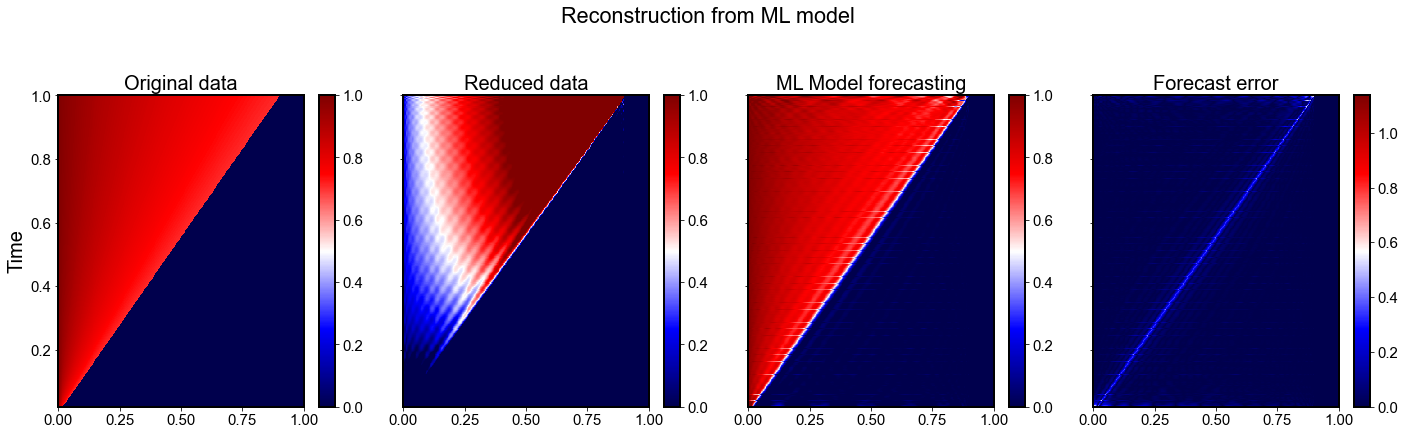

In [147]:
fig, ax = plt.subplots(1,4,sharey=True,figsize=(20, 6))
plt.suptitle('Reconstruction from ML model', y=1.02)

vmin = U_test2.min().min()
vmax = U_test2.max().max()

surf1 = ax[0].pcolor(X_test2, T_test2, U_test2, cmap=plt.get_cmap("seismic"),shading='auto',vmin=vmin, vmax=vmax)
ax[0].set_title('Original data')
ax[0].set_ylabel('Time')

surf2 = ax[1].pcolor(X_test2, T_test2, U_test_reduced2,cmap=plt.get_cmap("seismic"),shading='auto',vmin=vmin, vmax=vmax)
ax[1].set_title('Reduced data'.format(d))

surf3 = ax[2].pcolor(X_test2, T_test2, yhat,cmap=plt.get_cmap("seismic"),shading='auto',vmin=vmin, vmax=vmax)
ax[2].set_title('ML Model forecasting')

diff = abs(yhat-U_test2)
surf4 = ax[3].pcolor(X_test2,  T_test2, diff,cmap=plt.get_cmap("seismic"),shading='auto')
ax[3].set_title('Forecast error')

plt.colorbar(surf1, ax=ax[0])
plt.colorbar(surf2, ax=ax[1])
plt.colorbar(surf3, ax=ax[2])
plt.colorbar(surf4, ax=ax[3])

plt.tight_layout()
print('Mean absolute error (MAE) for forecasting: {}'.format(np.mean(diff.mean())))

- PCA MAE error for test set: 0.0340
- Forecasting MAE error:  0.016738

# Conclusions:

- The eigenvectors have very different shapes and characteristics, which lead to the bad model performance for some of them;
- Although the MAE metric is good, it fails to accurately model the shock interface 
- Better model tuning is necessary for better performance, however, better PCA performance would be more impactful

- Differently from the Kuramoto ROM, clear sazonality was present in the eigenvectors. Maybe SARIMA and its variants would lead to an overall better performance?